In [1]:
import astropy
from astropy.wcs import WCS
from astropy import wcs
from astropy.io import fits
from astropy.coordinates import Angle, SkyCoord
from astropy.nddata import Cutout2D
import astropy.units as un
import numpy as np
import pandas as pd
from matplotlib.patches import Ellipse, Rectangle
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

import warnings
warnings.filterwarnings("ignore")

#### Functions

In [2]:
def center(hdu):
    center_dict = {};
    center_dict = {"centpxl_ra": hdu.header['CRPIX1'], "centpxl_dec": hdu.header['CRPIX2'],
            "center_ra": hdu.header['CRVAL1'], "center_dec": hdu.header['CRVAL2'],
            "scale_ra": hdu.header['CDELT1'], "scale_dec": hdu.header['CDELT2'],
            "npxl_ra": hdu.header['NAXIS1'], "npxl_dec": hdu.header['NAXIS2']};
    
    return(center_dict)


def beam(hdu):
    beam_dict = {};
    beam_dict = {"b_major": hdu.header['BMAJ'], "b_minor": hdu.header['BMIN'], "b_pa": hdu.header['BPA']};
    #All units in degree
    
    return(beam_dict)


def info(hdu):
    info_dict = {};
    info_dict = { "obs_code": hdu.header['OBSERVER'], "obs_date": hdu.header['DATE-OBS'],
                 "obsra": hdu.header['OBSRA'], "obsdec": hdu.header['OBSDEC'],
                 "rms": hdu.header['NOISE'], "min": hdu.header['DATAMIN'], "max": hdu.header['DATAMAX']};
    
    return(info_dict)

def load(filename):
    hdu = fits.open(filename)[0];
    hdu_data = hdu.data[0][0];
    wcs_tmp = WCS(hdu.header);
    wcs_tmp1 = wcs_tmp.dropaxis(3);
    wcs = wcs_tmp1.dropaxis(2);
    
    return(hdu_data, wcs, hdu)

def cut(data, wcs, hdu, center, box):
    size = un.Quantity(box, un.pix);
    
    cutout = Cutout2D(data, position=center, size=size, wcs=wcs);
    hdu.header.update(cutout.wcs.to_header());
    hdu.data = cutout.data;
    wcs_cut = WCS(hdu.header);
    
    return(hdu.data, wcs_cut, hdu)

def scale(hdu, beam_dict, size):
    b_conv = (3600*1e3);
    beamsize = (beam_dict['b_major']*b_conv);
    sbar_scale = (size/beamsize);
    width = (beam_dict['b_major']*sbar_scale);

    return(width);

In [11]:
# ploting functions
def beam_plotter(beam_dict, center_dict, ax_name):
    
    ra_offset = (center_dict['npxl_ra']/2 + 10);
    dec_offset = (center_dict['npxl_dec']/2 - 5);
    beam_ra = (center_dict['center_ra'] - ra_offset*center_dict['scale_ra'] + beam_dict['b_major']); 
    beam_dec = (center_dict['center_dec'] - dec_offset*center_dict['scale_dec'] + beam_dict['b_major']);
    
    beam = Ellipse((beam_ra, beam_dec), height=beam_dict['b_major'], width = beam_dict['b_minor'], 
                   angle=beam_dict['b_pa'], transform=ax_name.get_transform('fk5'), edgecolor='w',
                   facecolor='w', alpha=0.7, lw=2);
    return(beam)

def sbar_plotter(center_dict, beam_dict, sbarwidth, ax_name, finetune_ra=0, finetune_dec=0):
                     
    sbar_ra_offset = (center_dict['npxl_ra']/2 - 55);
    sbar_dec_offset = (center_dict['npxl_dec']/2 - 20);
    sbar_rad = (center_dict['center_ra'] + sbar_ra_offset*center_dict['scale_ra']);
    sbar_dec = (center_dict['center_dec'] - sbar_dec_offset*center_dict['scale_dec']);
    sbar_ra_txt = (sbar_ra_offset/2 + 15 + finetune_ra);
    sbar_dec_txt = (sbar_dec_offset-5 + finetune_dec);
    sbar_txt_rad = (center_dict['center_ra'] + sbar_ra_txt*center_dict['scale_ra']);
    sbar_txt_dec = (center_dict['center_dec'] - sbar_dec_txt*center_dict['scale_dec']);

    sbar = Rectangle((sbar_rad, sbar_dec), width = sbar_width, height = beam_dict['b_minor']/10,
              transform=ax_name.get_transform('fk5'), color='w', facecolor='w', lw=2);
                     
    return(sbar, sbar_txt_rad, sbar_txt_dec);

def open(filename):
    img_data, wcs, image = load(filename);
    
    img_info = info(image);
    beam_data = beam(image);
    center_data = center(image);
    allinone = (img_info | beam_data | center_data);
    return(img_data, wcs, image, allinone)

#### Gaia

In [4]:
gaia_df = pd.read_csv('1688075645690O-result.csv', delimiter=',');
v1674her_df = gaia_df.iloc[3];
v1674her_gaia = v1674her_df.to_dict();
#ra_pm = un.Quantity(v1674her_gaia['pmra'], unit=(un.mas/un.year));

gaia = SkyCoord(v1674her_gaia['ra'], v1674her_gaia['dec'], unit=(un.degree, un.degree), 
                obstime="J2016", pm_ra_cosdec=(v1674her_gaia['pmra']*(un.mas/un.year)), 
                pm_dec=(v1674her_gaia['pmdec']*(un.mas/un.year)));


# shifted_gaia_tmp = gaia.apply_space_motion(new_obstime=astropy.time.Time(imgb_info['obs_date']));
# shifted_gaia = shifted_gaia_tmp.transform_to('fk5'); #AIPS uses FK5


#### Difmap Center from V1674HERB

In [5]:
difmap = SkyCoord(284.3790725790, 16.8943023350, unit=(un.degree, un.degree), 
                obstime="J2000", frame='fk5');
difmap

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (284.37907258, 16.89430233)>

### V1674HERD

In [16]:
imgd_data, wcsd, imaged = load('./V1674HERIMG/V1674HERD_CLN.fits');

imgd_info = info(imaged);
beamd = beam(imaged);
centerd = center(imaged);

cutd_data, cut_wcsd, cutd_hdu = cut(imgd_data, wcsd, imaged, center=difmap, box=(350,350));
center_newd = center(cutd_hdu);
sbar_widthd = scale(cutd_hdu, beamd, 10);
shifted_gaia_tmp = gaia.apply_space_motion(new_obstime=astropy.time.Time(imgd_info['obs_date']));
shifted_gaia = shifted_gaia_tmp.transform_to('fk5');


In [33]:
center_dict = center_newd
center_ra = center_dict['centpxl_ra'];
center_ra

120.0

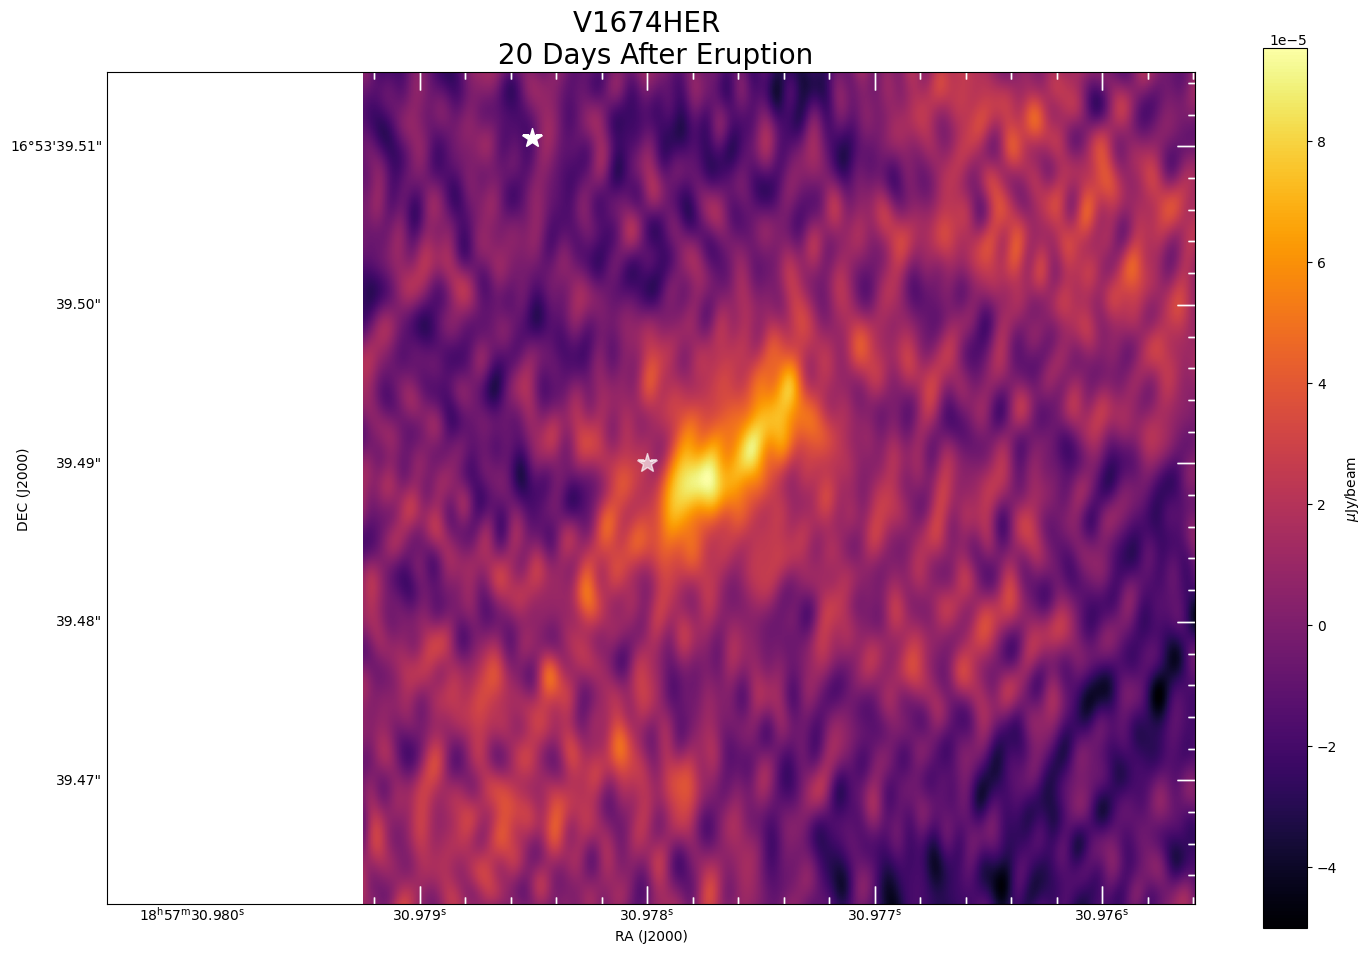

In [34]:
figd = plt.figure(figsize=(17,11));
axd = figd.add_axes([0.2, 0.2, 0.8, 0.8], projection=cut_wcsd, slices=('x','y',1,1));
ra_d = axd.coords[0];
dec_d = axd.coords[1];

axd.set_title(f'V1674HER \n 20 Days After Eruption', fontsize=20);

#axes ticks
dec_d.display_minor_ticks(True);
ra_d.display_minor_ticks(True);
axd.tick_params(which='both', direction='in', color='white', length=13, width=1);
axd.tick_params(which='minor', length=5);


imgd = axd.imshow(cutd_data, cmap='inferno', vmin=imgd_info['min'], vmax=imgd_info['max'], 
                 transform=axd.get_transform(cut_wcsd[0,0]), origin='lower');

cbar_d = figd.colorbar(imgd, location='right');
cbar_d.ax.set_ylabel(r'$\mu$Jy/beam');

ra_d.set_axislabel('RA (J2000)', minpad=1);
dec_d.set_axislabel('DEC (J2000)', minpad=-1.0);

beam_patchd = beam_plotter(beamd, center_newd, axd);


axd.add_patch(beam_patchd);

#scale_bard, sbard_txt_rad, sbard_txt_dec = sbar_plotter(center_newd, beamd, 10);
# scale_bard, sbard_txt_rad, sbard_txt_dec = sbar_plotter(40, 243, center_newd, beamd, 10);
# sbard_txt_rad = center_newd['center_ra'] + 165 *center_newd['scale_ra']
# sbard_txt_dec = center_newd['center_dec'] - 165*center_newd['scale_dec']
# sdartxt = '10 mas';
# axd.text(sbard_txt_rad, sbard_txt_dec, sbartxt, transform=axd.get_transform('fk5'), color='w', weight='bold');

#axd.add_patch(scale_bard);



axd.plot(shifted_gaia.ra.degree, shifted_gaia.dec.degree, transform=axd.get_transform('fk5'), 
         markersize=15, color='white', marker='*', label='Gaia position');

axd.plot(center_newd['center_ra'], center_newd['center_dec'], transform=axd.get_transform('fk5'), 
         markersize=15, color='white', marker='*', alpha=0.65, label='V1674HER position');